In [27]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [28]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import random

In [29]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [30]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [31]:
tf.keras.backend.clear_session()

In [32]:
subject = 'Acre - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 36
train_split = split_index + 1 - 12

In [33]:
data = pd.read_csv('2003_mo_model_input_AC.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Acre - Consumo de Cimento (t),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Acre - Desemprego,Acre - IDH,Acre - PIB - Estadual,Acre - PIB - Construção Civil,Acre - PIB - Per Capita,Acre - PIB - Preços de Mercado
0,2003-1,3.260,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,8.722906,0.691320,7.285707e+06,413409.255032,9.318417,6.587220e+06
1,2003-2,2.191,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,8.718028,0.691617,7.294881e+06,413607.843560,9.319990,6.590338e+06
2,2003-3,2.154,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,8.713149,0.691914,7.304055e+06,413806.432089,9.321563,6.593455e+06
3,2003-4,2.643,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,8.708271,0.692212,7.313229e+06,414005.020618,9.323136,6.596572e+06
4,2003-5,2.546,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,8.703393,0.692509,7.322403e+06,414203.609146,9.324709,6.599689e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,21.748,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
236,2022-9,20.032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
237,2022-10,18.573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
238,2022-11,15.493,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


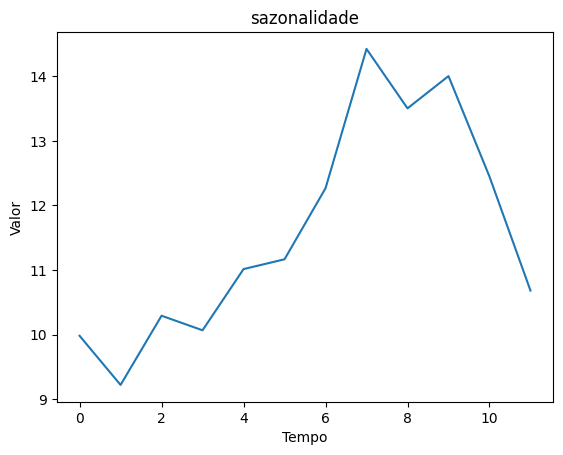

,sazonalidade
sazonalidade,
0,9.980980
1,9.220460
2,10.291804
3,10.066291
4,11.013849
5,11.165408
6,12.265823
7,14.422525
8,13.502440


In [34]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [35]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Acre - Desemprego,Acre - IDH,Acre - PIB - Estadual,Acre - PIB - Construção Civil,Acre - PIB - Per Capita,Acre - PIB - Preços de Mercado,sazonalidade,Acre - Consumo de Cimento (t)
0,2003-1,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,8.722906,0.691320,7.285707e+06,413409.255032,9.318417,6.587220e+06,9.980980,3.260
1,2003-2,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,8.718028,0.691617,7.294881e+06,413607.843560,9.319990,6.590338e+06,9.220460,2.191
2,2003-3,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,8.713149,0.691914,7.304055e+06,413806.432089,9.321563,6.593455e+06,10.291804,2.154
3,2003-4,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,8.708271,0.692212,7.313229e+06,414005.020618,9.323136,6.596572e+06,10.066291,2.643
4,2003-5,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,8.703393,0.692509,7.322403e+06,414203.609146,9.324709,6.599689e+06,11.013849,2.546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.422525,21.748
236,2022-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.502440,20.032
237,2022-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.001856,18.573
238,2022-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.445343,15.493


In [36]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      5.807
1      5.242
2      4.965
3      5.854
4      5.892
       ...  
235      NaN
236      NaN
237      NaN
238      NaN
239      NaN
Name: Acre - Consumo de Cimento (t), Length: 240, dtype: float64

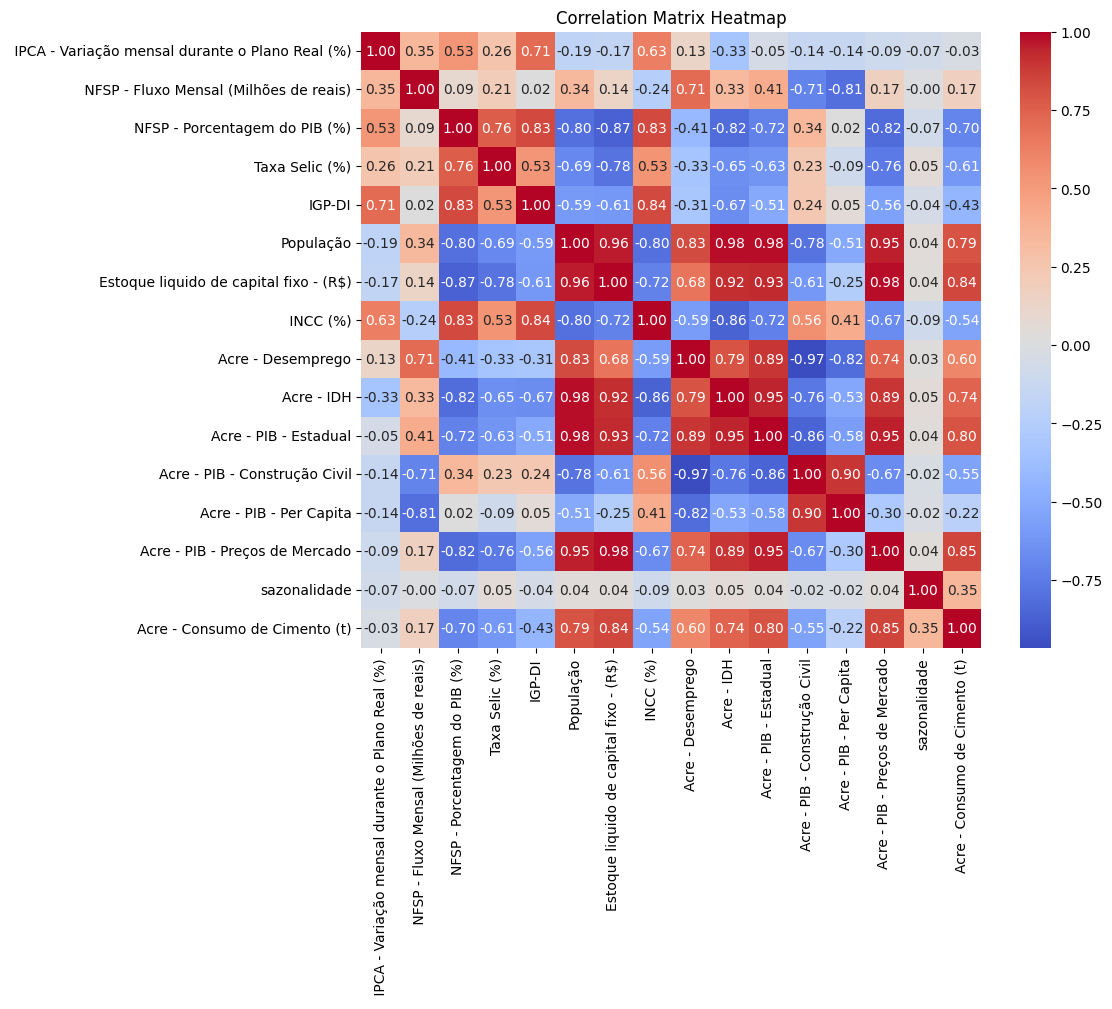

In [37]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [38]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [39]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,IPCA - Variação mensal durante o Plano Real (%),9.697497e+02
1,NFSP - Fluxo Mensal (Milhões de reais),2.432719e+02
2,NFSP - Porcentagem do PIB (%),1.499598e+02
3,Taxa Selic (%),5.306338e+01
4,IGP-DI,1.943963e+02
5,População,1.312542e+06
6,Estoque liquido de capital fixo - (R$),1.478610e+06
7,INCC (%),8.410215e+02
8,Acre - Desemprego,3.727275e+03
9,Acre - IDH,1.051107e+06


In [40]:
# data =data.drop(['Acre- custo m2 (R$)',
#                  'Acre - IDH Longevidade',
#                  'Acre - IDH Renda', 
#                  'Acre - PIB - Estadual'], axis=1)
data = remove_high_vif_columns(safe_data, 1000000)
data

Num columns removed: 2


,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,Estoque liquido de capital fixo - (R$),INCC (%),Acre - Desemprego,Acre - IDH,Acre - PIB - Estadual,Acre - PIB - Construção Civil,Acre - PIB - Per Capita,sazonalidade
0,0.724032,-5331.049150,11.520143,1.639718,1.036534,7.330309e+06,0.969649,8.722906,0.691320,7.285707e+06,413409.255032,9.318417,9.980980
1,0.690297,-5318.079644,11.189862,1.378899,0.993449,7.335910e+06,0.950783,8.718028,0.691617,7.294881e+06,413607.843560,9.319990,9.220460
2,0.669681,-5436.417870,10.820792,1.924317,0.973020,7.341511e+06,0.938332,8.713149,0.691914,7.304055e+06,413806.432089,9.321563,10.291804
3,0.660494,-5707.015274,10.417840,1.331174,0.940489,7.347112e+06,0.926401,8.708271,0.692212,7.313229e+06,414005.020618,9.323136,10.066291
4,0.648337,-5599.317941,9.959690,1.736072,0.917493,7.352713e+06,0.951683,8.703393,0.692509,7.322403e+06,414203.609146,9.324709,11.013849
...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.366904,-5783.316460,2.206994,0.545067,0.471521,7.783063e+06,0.378150,12.189263,0.720165,8.624684e+06,390265.764799,9.232189,14.422525
176,0.358935,-6001.730740,2.215328,0.782910,0.476827,7.780841e+06,0.377666,12.181187,0.720224,8.623631e+06,390439.148472,9.231720,13.502440
177,0.354313,-6454.887704,2.232466,0.909682,0.475427,7.778619e+06,0.377838,12.173112,0.720283,8.622579e+06,390612.532145,9.231251,14.001856
178,0.352728,-6243.191421,2.263185,1.050614,0.491301,7.776397e+06,0.370057,12.165036,0.720341,8.621526e+06,390785.915818,9.230783,12.445343


In [41]:
input_data = data
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,Estoque liquido de capital fixo - (R$),INCC (%),Acre - Desemprego,Acre - IDH,Acre - PIB - Estadual,Acre - PIB - Construção Civil,Acre - PIB - Per Capita,sazonalidade
0,2.802383,0.604311,4.268118,2.039314,3.921218,-2.299937,3.214079,-0.743171,-2.171102,-1.704243,0.414350,-0.535913,-0.980587
1,2.402642,0.609431,4.096014,1.195209,3.582946,-2.263992,3.051841,-0.746212,-2.132642,-1.684197,0.431295,-0.509562,-1.444606
2,2.158351,0.562720,3.903698,2.960381,3.422548,-2.228047,2.944772,-0.749254,-2.094182,-1.664151,0.448239,-0.483210,-0.790943
3,2.049492,0.455907,3.693727,1.040752,3.167136,-2.192102,2.842174,-0.752295,-2.055723,-1.644106,0.465183,-0.456859,-0.928536
4,1.905441,0.498418,3.454992,2.351150,2.986591,-2.156157,3.059587,-0.755336,-2.017263,-1.624060,0.482128,-0.430507,-0.350398
...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,-1.429358,0.425789,-0.584804,-1.503380,-0.514871,0.605679,-1.872446,1.417873,1.559523,1.221491,-1.560335,-1.980523,1.729351
176,-1.523783,0.339575,-0.580461,-0.733634,-0.473208,0.591420,-1.876611,1.412839,1.567120,1.219191,-1.545541,-1.988375,1.167976
177,-1.578548,0.160702,-0.571531,-0.323353,-0.484199,0.577161,-1.875135,1.407804,1.574718,1.216891,-1.530748,-1.996227,1.472687
178,-1.597335,0.244264,-0.555524,0.132757,-0.359568,0.562902,-1.942040,1.402770,1.582315,1.214591,-1.515954,-2.004079,0.523005


In [42]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,Estoque liquido de capital fixo - (R$),INCC (%),Acre - Desemprego,Acre - IDH,Acre - PIB - Estadual,Acre - PIB - Construção Civil,Acre - PIB - Per Capita,sazonalidade
0,2.802383,0.604311,4.268118,2.039314,3.921218,-2.299937,3.214079,-0.743171,-2.171102,-1.704243,0.414350,-0.535913,-0.980587
1,2.402642,0.609431,4.096014,1.195209,3.582946,-2.263992,3.051841,-0.746212,-2.132642,-1.684197,0.431295,-0.509562,-1.444606
2,2.158351,0.562720,3.903698,2.960381,3.422548,-2.228047,2.944772,-0.749254,-2.094182,-1.664151,0.448239,-0.483210,-0.790943
3,2.049492,0.455907,3.693727,1.040752,3.167136,-2.192102,2.842174,-0.752295,-2.055723,-1.644106,0.465183,-0.456859,-0.928536
4,1.905441,0.498418,3.454992,2.351150,2.986591,-2.156157,3.059587,-0.755336,-2.017263,-1.624060,0.482128,-0.430507,-0.350398
...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,-0.960452,1.465326,-0.676734,0.472779,-1.087000,0.759879,-1.491033,1.508258,1.520921,1.227396,-1.663997,-1.843725,1.729351
164,-1.007966,1.351131,-0.668750,0.302784,-0.904679,0.749001,-1.525186,1.497229,1.518005,1.229435,-1.663976,-1.860092,1.167976
165,-0.976556,1.143146,-0.657609,0.339539,-0.900134,0.738124,-1.546744,1.486201,1.515090,1.231474,-1.663955,-1.876459,1.472687
166,-1.146834,1.542609,-0.647588,0.472795,-1.136836,0.727246,-1.586381,1.475172,1.512174,1.233513,-1.663934,-1.892826,0.523005


In [43]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0       5.807
1       5.242
2       4.965
3       5.854
4       5.892
        ...  
163    15.749
164    14.269
165    15.367
166    14.595
167     9.811
Name: Acre - Consumo de Cimento (t), Length: 168, dtype: float64

In [44]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [45]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(132, 36, 13)

In [46]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,Estoque liquido de capital fixo - (R$),INCC (%),Acre - Desemprego,Acre - IDH,Acre - PIB - Estadual,Acre - PIB - Construção Civil,Acre - PIB - Per Capita,sazonalidade
132,1.530065,0.817451,-0.366715,-0.530011,0.174628,0.965586,-0.066954,1.092239,0.545487,1.082112,-0.669697,-0.119584,-0.980587
133,1.649361,1.130195,-0.350285,-0.532694,0.240832,0.962419,-0.130652,1.116799,0.543084,1.088707,-0.731996,-0.201625,-1.444606
134,1.622916,1.160498,-0.335122,-0.186421,0.176857,0.959252,-0.079602,1.141358,0.540681,1.095302,-0.794295,-0.283665,-0.790943
135,1.581460,1.131990,-0.321950,-0.719664,-0.005233,0.956085,-0.034473,1.165918,0.538278,1.101897,-0.856594,-0.365706,-0.928536
136,1.638292,1.384387,-0.302995,-0.798520,0.097576,0.952918,-0.177535,1.190478,0.535875,1.108492,-0.918893,-0.447746,-0.350398
137,1.643773,1.375487,-0.290554,-0.612129,0.431487,0.949751,-0.208868,1.215038,0.533472,1.115087,-0.981192,-0.529787,-0.257927
138,1.704584,1.438928,-0.281926,-0.476740,0.482414,0.946584,-0.245300,1.239597,0.531069,1.121682,-1.043491,-0.611827,0.413474
139,1.841703,1.569590,-0.275931,-0.211736,0.657043,0.943417,-0.333490,1.264157,0.528666,1.128277,-1.105791,-0.693868,1.729351
140,1.837218,1.584058,-0.271466,-0.484608,0.678386,0.940250,-0.296846,1.288717,0.526263,1.134872,-1.168090,-0.775908,1.167976
141,1.797860,1.166380,-0.273241,-0.183907,0.727143,0.937082,-0.292462,1.313277,0.523860,1.141467,-1.230389,-0.857949,1.472687


In [47]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 13)

In [48]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(144, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(144, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.1,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [49]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [50]:
def predictor(model, test_input, test_target, start_target):
    
    predictions = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        if (prediction[0][0] < 0.0):
            return None, None, None
        predictions.append(prediction[0][0])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])
    mape = np.mean(df_results["Error"])/np.mean(df_results["Target"])

    return df_results, predictions, mape

In [51]:
def statistical_validator(train_input, train_target, test_input, test_target, start_target):
    
    pd.set_option('display.max_columns', None)
    predictions_list = []
    error_percent = []
    
    i = 0
    while i < 10:
        winner_seed = get_a_good_seed(train_input, train_target, test_input, test_target)
        trained_model, history = lstm_model(train_input, 
                                            train_target, 
                                            want_verbose=0, 
                                            seed=winner_seed)
        df_results, predictions, mape = predictor(trained_model, 
                                            test_input, 
                                            test_target, 
                                            start_index)
        if predictions is not None:
            display(f"\n\Results: {i} ___________________________________________\n")
            display(df_results.T)
            display(mape)
            predictions_list.append(predictions)
            i += 1
        
    predictions_means = np.mean(predictions_list, axis=0)
    results_data = []
   
    for j in range(12):
        target = test_target[start_target + j]
        error = np.abs(predictions_means[j] - target)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                            predictions_means[j], 
                            target, 
                            error])
    display("FINAL___________________________________________________________________")
    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])
    display(df_results.T)
        
    mae_mean = np.mean(predictions_means)
    mape_mean = np.mean(error_percent) 

    return mae_mean, mape_mean

In [52]:
mae, mape = statistical_validator(reshaped_train, 
                                  reshaped_target, 
                                  reshaped_test, 
                                  reshaped_test_target, 
                                  start_index)

[4072883703, 4036704619, 1389634255, 2213831313, 2647281569, 3208316175, 1305342874, 3435796340, 3936540166, 1652585309]


Step: 0 ___________________________________________
val_loss: 5.978660583496094
winner_seed: 4072883703


Step: 1 ___________________________________________
val_loss: 2.4007160663604736
winner_seed: 4036704619


Step: 2 ___________________________________________
val_loss: 13.43621826171875


Step: 3 ___________________________________________
val_loss: 1.8291723728179932
winner_seed: 2213831313


Step: 4 ___________________________________________
val_loss: 3.53959584236145


Step: 5 ___________________________________________
val_loss: 8.23327350616455


Step: 6 ___________________________________________
val_loss: 6.393519401550293


Step: 7 ___________________________________________
val_loss: 8.332670211791992


Step: 8 ___________________________________________
val_loss: 7.3443708419799805


Step: 9 ___________________________________________
val_loss: 6.00

'\n\\Results: 0 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,7.570827,6.55938,8.803695,10.782969,11.673851,12.517202,13.12716,13.06748,11.85035,10.007508,9.23076,11.832063
Target,11.188,10.381,8.08,11.154,12.508,12.126,14.496,16.723,15.253,16.531,15.206,10.16
Error,3.617173,3.82162,0.723695,0.371032,0.834149,0.391202,1.36884,3.655519,3.40265,6.523492,5.975241,1.672063


2.69639

[1230676535, 740729017, 114906968, 3931537137, 3748710637, 2905718074, 2863992511, 4052143198, 3463219175, 3866166406]


Step: 0 ___________________________________________
val_loss: 4.793690204620361
winner_seed: 1230676535


Step: 1 ___________________________________________
val_loss: 2.3324954509735107
winner_seed: 740729017


Step: 2 ___________________________________________
val_loss: 2.477944850921631


Step: 3 ___________________________________________
val_loss: 8.314985275268555


Step: 4 ___________________________________________
val_loss: 4.638617515563965


Step: 5 ___________________________________________
val_loss: 8.878037452697754


Step: 6 ___________________________________________
val_loss: 12.29216480255127


Step: 7 ___________________________________________
val_loss: 12.075474739074707


Step: 8 ___________________________________________
val_loss: 3.1670925617218018


Step: 9 ___________________________________________
val_loss: 4.37555456161499
1/1 [=======

'\n\\Results: 1 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,11.2984,11.633543,12.284536,12.7562,13.050612,13.109424,12.947737,12.617225,12.114835,11.76971,11.454384,11.182212
Target,11.188,10.381,8.08,11.154,12.508,12.126,14.496,16.723,15.253,16.531,15.206,10.16
Error,0.1104,1.252543,4.204536,1.6022,0.542612,0.983423,1.548264,4.105775,3.138165,4.761291,3.751616,1.022212


2.25192

[2876724175, 1847385057, 1463547885, 3354986887, 3971212627, 2553819799, 4033792284, 2598331612, 1286387277, 4279954867]


Step: 0 ___________________________________________
val_loss: 8.70480728149414
winner_seed: 2876724175


Step: 1 ___________________________________________
val_loss: 12.996232032775879


Step: 2 ___________________________________________
val_loss: 9.806013107299805


Step: 3 ___________________________________________
val_loss: 7.000217437744141
winner_seed: 3354986887


Step: 4 ___________________________________________
val_loss: 13.612348556518555


Step: 5 ___________________________________________
val_loss: 6.332177639007568
winner_seed: 2553819799


Step: 6 ___________________________________________
val_loss: 11.60193157196045


Step: 7 ___________________________________________
val_loss: 7.822574615478516


Step: 8 ___________________________________________
val_loss: 4.912069797515869
winner_seed: 1286387277


Step: 9 __________________________________

'\n\\Results: 2 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,11.563506,12.413668,12.124928,11.950175,11.870198,11.889252,11.937853,12.0116,12.130045,12.365358,12.648572,12.948793
Target,11.188,10.381,8.08,11.154,12.508,12.126,14.496,16.723,15.253,16.531,15.206,10.16
Error,0.375506,2.032668,4.044929,0.796175,0.637802,0.236749,2.558147,4.7114,3.122955,4.165642,2.557428,2.788794


2.3356829

[1638304059, 503833341, 1965261317, 90382664, 2377357476, 180409330, 1277754555, 2111297027, 4098176547, 3153300449]


Step: 0 ___________________________________________
val_loss: 3.5796523094177246
winner_seed: 1638304059


Step: 1 ___________________________________________
val_loss: 9.900988578796387


Step: 2 ___________________________________________
val_loss: 5.087453365325928


Step: 3 ___________________________________________
val_loss: 8.901984214782715


Step: 4 ___________________________________________
val_loss: 3.816549301147461


Step: 5 ___________________________________________
val_loss: 4.373676300048828


Step: 6 ___________________________________________
val_loss: 4.545042991638184


Step: 7 ___________________________________________
val_loss: 3.3850998878479004
winner_seed: 2111297027


Step: 8 ___________________________________________
val_loss: 14.424756050109863


Step: 9 ___________________________________________
val_loss: 12.914461135864258
1/1 [======

'\n\\Results: 3 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,13.825343,13.604342,13.2344,12.963402,12.944347,13.193195,14.197906,14.679708,14.433638,14.634037,14.619074,14.420221
Target,11.188,10.381,8.08,11.154,12.508,12.126,14.496,16.723,15.253,16.531,15.206,10.16
Error,2.637343,3.223342,5.1544,1.809402,0.436347,1.067195,0.298094,2.043291,0.819363,1.896963,0.586926,4.260221


2.0194075

[2561613997, 607895011, 2927217814, 1754503473, 581443359, 643986088, 977280508, 1420901847, 3237092295, 3848714085]


Step: 0 ___________________________________________
val_loss: 9.699509620666504
winner_seed: 2561613997


Step: 1 ___________________________________________
val_loss: 11.05931568145752


Step: 2 ___________________________________________
val_loss: 5.141165256500244
winner_seed: 2927217814


Step: 3 ___________________________________________
val_loss: 5.189545154571533


Step: 4 ___________________________________________
val_loss: 3.3617374897003174
winner_seed: 581443359


Step: 5 ___________________________________________
val_loss: 3.7901556491851807


Step: 6 ___________________________________________
val_loss: 10.78505802154541


Step: 7 ___________________________________________
val_loss: 9.71173095703125


Step: 8 ___________________________________________
val_loss: 4.825721263885498


Step: 9 ___________________________________________
val_loss: 5.9460115

'\n\\Results: 4 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,12.984244,13.524626,14.144717,14.278749,14.198494,14.058736,13.926832,13.819066,13.737935,13.702106,13.531629,13.113237
Target,11.188,10.381,8.08,11.154,12.508,12.126,14.496,16.723,15.253,16.531,15.206,10.16
Error,1.796245,3.143626,6.064717,3.124748,1.690494,1.932735,0.569168,2.903934,1.515065,2.828895,1.674372,2.953238


2.5164363

[467749682, 667295373, 1977213302, 1885805386, 2090870777, 2165534180, 3696899330, 824502707, 1929910362, 3158091839]


Step: 0 ___________________________________________
val_loss: 8.752542495727539
winner_seed: 467749682


Step: 1 ___________________________________________
val_loss: 9.349044799804688


Step: 2 ___________________________________________
val_loss: 4.1876540184021
winner_seed: 1977213302


Step: 3 ___________________________________________
val_loss: 5.795956134796143


Step: 4 ___________________________________________
val_loss: 7.9016313552856445


Step: 5 ___________________________________________
val_loss: 11.894843101501465


Step: 6 ___________________________________________
val_loss: 7.610843658447266


Step: 7 ___________________________________________
val_loss: 8.693885803222656


Step: 8 ___________________________________________
val_loss: 17.2829647064209


Step: 9 ___________________________________________
val_loss: 3.8271615505218506
winner_seed: 31

'\n\\Results: 5 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,11.63096,12.277905,12.803185,12.968845,15.21032,15.098728,13.367117,13.347515,12.978006,12.841154,12.614943,12.408569
Target,11.188,10.381,8.08,11.154,12.508,12.126,14.496,16.723,15.253,16.531,15.206,10.16
Error,0.442961,1.896905,4.723185,1.814845,2.702319,2.972728,1.128883,3.375484,2.274994,3.689846,2.591058,2.248569


2.4884815

[3938394145, 2922011963, 2677288514, 1764696986, 108842903, 3012615319, 2303224239, 1089813077, 1154071325, 2845099165]


Step: 0 ___________________________________________
val_loss: 11.654958724975586
winner_seed: 3938394145


Step: 1 ___________________________________________
val_loss: 6.957625389099121
winner_seed: 2922011963


Step: 2 ___________________________________________
val_loss: 10.426459312438965


Step: 3 ___________________________________________
val_loss: 6.655105113983154
winner_seed: 1764696986


Step: 4 ___________________________________________
val_loss: 4.9298882484436035
winner_seed: 108842903


Step: 5 ___________________________________________
val_loss: 6.658572673797607


Step: 6 ___________________________________________
val_loss: 8.152838706970215


Step: 7 ___________________________________________
val_loss: 9.099350929260254


Step: 8 ___________________________________________
val_loss: 7.745052814483643


Step: 9 __________________________________

'\n\\Results: 6 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,12.409184,11.959847,12.4582,13.926202,15.189084,14.459377,14.368115,14.5474,14.700648,14.588506,14.323205,13.864828
Target,11.188,10.381,8.08,11.154,12.508,12.126,14.496,16.723,15.253,16.531,15.206,10.16
Error,1.221185,1.578848,4.3782,2.772202,2.681084,2.333377,0.127885,2.175599,0.552352,1.942494,0.882795,3.704828


2.0292375

[1170478691, 4105534898, 3649826498, 1518281937, 4276716150, 605122458, 3881495682, 2072329211, 805047934, 397068464]


Step: 0 ___________________________________________
val_loss: 4.146702289581299
winner_seed: 1170478691


Step: 1 ___________________________________________
val_loss: 13.009269714355469


Step: 2 ___________________________________________
val_loss: 7.866562366485596


Step: 3 ___________________________________________
val_loss: 5.765872001647949


Step: 4 ___________________________________________
val_loss: 17.726346969604492


Step: 5 ___________________________________________
val_loss: 4.096848011016846
winner_seed: 605122458


Step: 6 ___________________________________________
val_loss: 3.0489342212677
winner_seed: 3881495682


Step: 7 ___________________________________________
val_loss: 7.835834980010986


Step: 8 ___________________________________________
val_loss: 8.240812301635742


Step: 9 ___________________________________________
val_loss: 4.7339777

'\n\\Results: 7 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,11.131901,10.989614,11.041175,11.265105,12.241868,13.267988,14.969146,16.021465,16.353115,16.352161,15.990775,15.297542
Target,11.188,10.381,8.08,11.154,12.508,12.126,14.496,16.723,15.253,16.531,15.206,10.16
Error,0.056099,0.608614,2.961175,0.111105,0.266132,1.141988,0.473145,0.701534,1.100115,0.178839,0.784775,5.137542


1.1267552

[4202965499, 1167629565, 709681671, 1395422468, 4149751301, 3987545076, 505020571, 1611072393, 1512688025, 3998048614]


Step: 0 ___________________________________________
val_loss: 10.006551742553711
winner_seed: 4202965499


Step: 1 ___________________________________________
val_loss: 4.52292013168335
winner_seed: 1167629565


Step: 2 ___________________________________________
val_loss: 8.522780418395996


Step: 3 ___________________________________________
val_loss: 4.2036333084106445
winner_seed: 1395422468


Step: 4 ___________________________________________
val_loss: 6.297005653381348


Step: 5 ___________________________________________
val_loss: 3.798443555831909
winner_seed: 3987545076


Step: 6 ___________________________________________
val_loss: 9.14238166809082


Step: 7 ___________________________________________
val_loss: 4.6436052322387695


Step: 8 ___________________________________________
val_loss: 10.281091690063477


Step: 9 ___________________________________

'\n\\Results: 8 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,14.130584,14.671416,15.143439,15.58805,16.080219,16.654522,17.243553,17.713997,17.931656,18.041756,17.993252,18.037922
Target,11.188,10.381,8.08,11.154,12.508,12.126,14.496,16.723,15.253,16.531,15.206,10.16
Error,2.942584,4.290417,7.063439,4.43405,3.572219,4.528522,2.747553,0.990997,2.678656,1.510756,2.787251,7.877922


3.785364

[2842941001, 3505707143, 3073732790, 2330138575, 1010771851, 1885949633, 3066916129, 1607558002, 382890583, 978883537]


Step: 0 ___________________________________________
val_loss: 8.180292129516602
winner_seed: 2842941001


Step: 1 ___________________________________________
val_loss: 10.195798873901367


Step: 2 ___________________________________________
val_loss: 6.661722660064697
winner_seed: 3073732790


Step: 3 ___________________________________________
val_loss: 4.418953895568848
winner_seed: 2330138575


Step: 4 ___________________________________________
val_loss: 5.686367988586426


Step: 5 ___________________________________________
val_loss: 3.233548879623413
winner_seed: 1885949633


Step: 6 ___________________________________________
val_loss: 11.007143020629883


Step: 7 ___________________________________________
val_loss: 10.711518287658691


Step: 8 ___________________________________________
val_loss: 4.4601874351501465


Step: 9 _________________________________

'\n\\Results: 9 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,9.460091,9.88214,9.481405,11.91511,14.006605,14.344172,15.437196,16.570456,16.296379,14.011514,13.435109,12.984504
Target,11.188,10.381,8.08,11.154,12.508,12.126,14.496,16.723,15.253,16.531,15.206,10.16
Error,1.727909,0.498859,1.401405,0.761109,1.498605,2.218171,0.941195,0.152544,1.043379,2.519486,1.770891,2.824504


1.446505

'FINAL___________________________________________________________________'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11
Prediction,11.600504,11.751648,12.151968,12.83948,13.646561,13.859261,14.152263,14.439592,14.252661,13.831381,13.584169,13.608988
Target,11.188,10.381,8.08,11.154,12.508,12.126,14.496,16.723,15.253,16.531,15.206,10.16
Error,0.412504,1.370648,4.071968,1.68548,1.138561,1.733261,0.343737,2.283408,1.000339,2.699619,1.621831,3.448988


In [53]:
display(mae)
display(mape)

13.309873

0.15776705741516597